#### Cost-Effective Personalized Policies for Implementing Organ-at-Risk Sparing Adaptive Radiation Therapy in Head and Neck Cancer
Copyright (c) 2024 Daniel Suarez Aguirre \&  Seyedmohammadhossein Hosseinian. All rights reserved.
### MDP model

In [1]:
#uncomment if not installed
#!pip install pymdptoolbox
#!pip uninstall matplotlib
#!pip install matplotlib==3.7.3
import numpy as np
from mdptoolbox.mdp import ValueIteration
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Parameters
## Time Horizon
T = 5

##5-year survival rate 
S_values = {'overall': 0.685,
     'HPV+': 0.80,
     'HPV-': 0.40}

cancer_knowledge = 'overall'
#cancer_knowledge = 'HPV+'
#cancer_knowledge = 'HPV-'

S = S_values[cancer_knowledge]


## Quality of Life factor
Q_values = {'conservative':0.80,
    'xerostomia':0.85,
    'dysphagia':0.827
    }

side_effect = 'conservative'
#side_effect = 'xerostomia'
#side_effect = 'dysphagia'

Q = Q_values[side_effect]

## set discount factor
discount_factor = 0.99999

In [3]:
# helper function for reading data files

def load_csv_with_bom(file_path):
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        return np.loadtxt(f, delimiter=',')
# Load Transition Probabilities
prob_F0010 = load_csv_with_bom('data/prob_F0010.csv')
prob_DN = load_csv_with_bom('data/prob_DN.csv')
prob_F1015_RP = load_csv_with_bom('data/prob_F1015_RP.csv')
prob_F1520_RP = load_csv_with_bom('data/prob_F1520_RP.csv')
prob_F2025_RP = load_csv_with_bom('data/prob_F2025_RP.csv')
prob_F2530_RP = load_csv_with_bom('data/prob_F2530_RP.csv')

In [4]:
# Modular Function for MDP setting 
# Change in QALY from \delta NTCP
def QALY_gains(Q, T, S, delta_NTCP: float):
    delta_QALY = T * S * delta_NTCP * (1 - Q)
    return delta_QALY

# monetary value of health benefit
def health_benefit(Q, T, S, delta_NTCP, W):
    delta_QALY = QALY_gains(Q, T, S, delta_NTCP)
    return W * delta_QALY

# Set probabilities and rewards for the MDP
def probabilities_and_rewards(Q, S, T, W, C):
    #Rewards
    rew_F0010_DN = np.zeros(13)
    rew_F0010_RP = -1_000_000 * np.ones(13) #large number because one cannot replan at this stage

    #for F1015, F1520, F2025 reward is cost of action
    rew_F1015_DN = np.zeros((13,13))
    rew_F1520_DN = np.zeros((13,13))
    rew_F2025_DN = np.zeros((13,13))

    rew_F1015_RP = -C * np.ones((13,13))
    rew_F1520_RP = -C * np.ones((13,13))
    rew_F2025_RP = -C * np.ones((13,13))

    #for F2530 the reward is the health benefit of each final state delta_NTCP and the cost of action
    health_benefits = np.array(range(13)) #benefits for each final state delta_NTCP
    for i in range(13):
        health_benefits[i] = health_benefit(Q, T, S, - i/100, W) 

    rew_F2530_DN = np.zeros((13,13))
    rew_F2530_RP = np.zeros((13,13))
    for i in range(13):
        rew_F2530_DN[i,:] = health_benefits
        rew_F2530_RP[i,:] = health_benefits - C 


    #States
    States = ["F0-0%",
            "F10-0%", "F10-1%", "F10-2%", "F10-3%", "F10-4%", "F10-5%", "F10-6%",
            "F10-7%", "F10-8%", "F10-9%", "F10-10%", "F10-11%", "F10-12%",
            "F15-0%", "F15-1%", "F15-2%", "F15-3%", "F15-4%", "F15-5%", "F15-6%",
            "F15-7%", "F15-8%", "F15-9%", "F15-10%", "F15-11%", "F15-12%",
            "F20-0%", "F20-1%", "F20-2%", "F20-3%", "F20-4%", "F20-5%", "F20-6%",
            "F20-7%", "F20-8%", "F20-9%", "F20-10%", "F20-11%", "F20-12%",
            "F25-0%", "F25-1%", "F25-2%", "F25-3%", "F25-4%", "F25-5%", "F25-6%",
            "F25-7%", "F25-8%", "F25-9%", "F25-10%", "F25-11%", "F25-12%",
            "F30-0%", "F30-1%", "F30-2%", "F30-3%", "F30-4%", "F30-5%",
            "F30-6%", "F30-7%", "F30-8%", "F30-9%", "F30-10%", "F30-11%", "F30-12%",
            "F_end"]

    #Number of states
    N = 67

    # Initialize P and R
    P = np.zeros((2, N, N))
    R = np.zeros((2, N, N))

    # F00 
    P[0, 0, 1:14] = prob_F0010
    P[1, 0, 1:14] = prob_F0010
    R[0, 0, 1:14] = rew_F0010_DN
    R[1, 0, 1:14] = rew_F0010_RP

    #F10
    P[0, 1:14, 14:27] = prob_DN
    P[1, 1:14, 14:27] = prob_F1015_RP
    R[0, 1:14, 14:27] = rew_F1015_DN
    R[1, 1:14, 14:27] = rew_F1015_RP

    # F15
    P[0, 14:27, 27:40] = prob_DN
    P[1, 14:27, 27:40] = prob_F1520_RP
    R[0, 14:27, 27:40] = rew_F1520_DN
    R[1, 14:27, 27:40] = rew_F1520_RP

    # F20
    P[0, 27:40, 40:53] = prob_DN
    P[1, 27:40, 40:53] = prob_F2025_RP
    R[0, 27:40, 40:53] = rew_F2025_DN
    R[1, 27:40, 40:53] = rew_F2025_RP

    # F25
    P[0, 40:53, 53:66] = prob_DN
    P[1, 40:53, 53:66] = prob_F2530_RP
    R[0, 40:53, 53:66] = rew_F2530_DN
    R[1, 40:53, 53:66] = rew_F2530_RP

    # F30
    P[0, 53:66, 66:67] = np.ones((13, 1)) 
    P[1, 53:66, 66:67] = np.ones((13, 1)) 
    R[0, 53:66, 66:67] = np.zeros((13, 1)) 
    R[1, 53:66, 66:67] = -C * np.ones((13,1))

    #F_end
    P[0, 66, 66] = 1. 
    P[1, 66, 66] = 1. 
    R[0, 66, 66] = 0.
    R[1, 66, 66] = -C #unfeasible to replan at this stage, negative value ensures that replanning is not chosen

    return P, R, N, States

# solve MDP using Value Iteration
def solve_MDP_vi(P, R, discount_factor):
    # Initialize value iteration solver
    vi = ValueIteration(P, R, discount_factor)
    # Run the solver
    vi.run()
    # Extract the optimal policy
    policy = vi.policy
    values = vi.V
    return policy, values

# Run 
def Cost_Effective_ART_MDP_run(Q,S,T,W,C):
    P, R, N, States = probabilities_and_rewards(Q, S, T, W, C)
    policy, values = solve_MDP_vi(P, R, discount_factor)
    return policy, values

In [5]:
#helper functions to show results
def display_policy(policy, optimal = False):
    if optimal: print("Optimal Policy:")
    else: print("Policy:")
    print('F00:', policy[0])
    print('F10:', policy[1:14])
    print('F15:', policy[14:27])
    print('F20:', policy[27:40])
    print('F25:', policy[40:53])
    print('F30:', policy[53:66])
    print('F_end:', policy[66])

def display_values(values):
    print("State Values:")
    print('F00:', np.round(values[0],1))
    print('F10:', np.round(values[1:14],1))
    print('F15:', np.round(values[14:27],1))
    print('F20:', np.round(values[27:40],1))
    print('F25:', np.round(values[40:53],1))
    print('F30:', np.round(values[53:66],1))
    print('F_end:', np.round(values[66],1))

def policy_to_array(policy):
    policy_array = np.zeros((4, 13))
    policy_array[0,:] = policy[1:14]
    policy_array[1,:] = policy[14:27]
    policy_array[2,:] = policy[27:40]
    policy_array[3,:] = policy[40:53]
    return policy_array


def policy_to_tresholds(policy):
    epochs = [10, 15, 20, 25]
    policy_array = policy_to_array(policy)
    tresholds = []
    for epoch in epochs:
        index_max = np.argmax(policy_array[epochs.index(epoch)])
        if policy_array[epochs.index(epoch)][index_max] == 0:
            tresholds.append(99)
        else:
            tresholds.append(index_max)
    return tresholds

def plot_treshold_costs(Q: float, S: float, T:int, W:float, costs:list):
    epochs = [10, 15, 20, 25]
    costs = costs[::-1]
    tresholds_array = np.array([policy_to_tresholds(Cost_Effective_ART_MDP_run(Q, S, T, W, C)[0]) for C in costs])
    #heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(tresholds_array, cmap='Spectral_r', annot = True,  xticklabels=epochs, yticklabels=costs, vmin=0, vmax=13)
    plt.xlabel('Treatment Fraction')
    plt.ylabel('Replanning Cost ($)')
    plt.title('Optimal \u0394NTCP (%) Tresholds for ART \n \n')
    plt.text(0, 0, 'Q: {:.2f}, S: {:.3f}, T: {}, W: {} \n'.format(Q, S, T, W))
    #plt.savefig(f'W={int(W/1000)}k.png')
    plt.show()

# Plots

In [6]:
costs = [500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,1900,2000] 

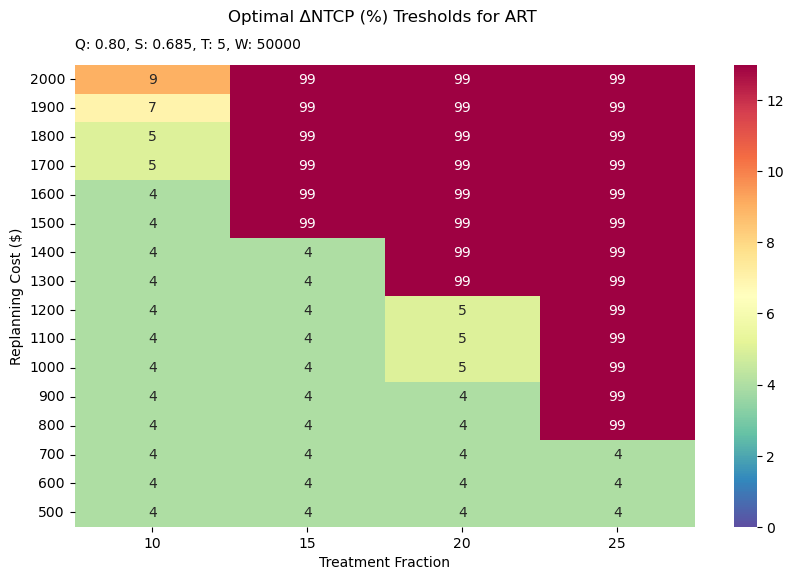

*************
Cost = $ 500
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F20: (0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 ***Thresholds:  [4, 4, 4, 4] 

State Values:
F00: -515.2
F10: [ -270.3  -349.1  -477.   -710.6  -849.1  -977.   -977.   -977.  -1210.6
 -1210.6 -1210.6 -1691.8 -1691.8]
F15: [ -230.6  -345.9  -507.3  -825.5 -1007.3 -1325.5 -1325.5 -2189.7 -2189.7
 -2395.8 -2395.8 -2577.9 -2577.9]
F20: [ -176.7  -343.4  -545.8  -882.2 -1382.2 -1382.2 -2092.5 -2404.2 -2672.4
 -2592.5 -2904.2 -2904.2 -3246. ]
F25: [ -102.6  -342.   -602.   -934.2 -1434.2 -2030.5 -2064.4 -2400.4 -2742.5
 -3085.4 -3242.5 -3444.6 -3910.4]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0


*************
Cost = $ 600
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 

In [7]:
W = 50_000
plot_treshold_costs(Q,S,T,W,costs)
#
for C in costs:
    print('*************')
    print('Cost = $',C)
    print('*************')
    policy, values = Cost_Effective_ART_MDP_run(Q, S, T, W, C)
    display_policy(policy, optimal = True)
    print('\n ***Thresholds: ', policy_to_tresholds(policy), '\n')
    display_values(values)
    print('\n')

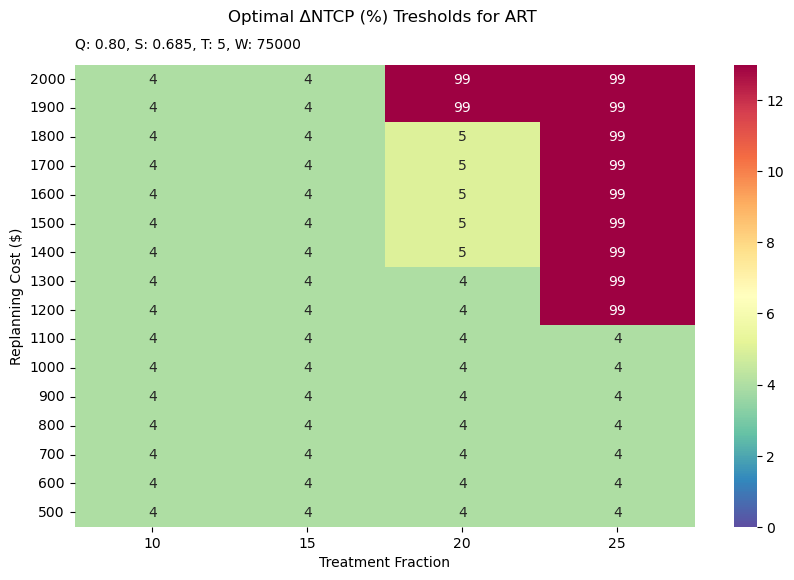

*************
Cost = $ 500
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F20: (0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 ***Thresholds:  [4, 4, 4, 4] 

State Values:
F00: -699.0
F10: [ -404.7  -523.3  -706.4  -988.7 -1023.3 -1206.4 -1206.4 -1206.4 -1488.7
 -1488.7 -1488.7 -2004.4 -2004.4]
F15: [ -345.9  -518.9  -755.  -1169.2 -1255.  -1669.2 -1669.2 -2834.1 -2834.1
 -3192.9 -3192.9 -3485.7 -3485.7]
F20: [ -265.2  -515.3  -816.7 -1281.5 -1781.5 -1781.5 -3005.4 -3602.7 -3746.1
 -3639.1 -4102.7 -4102.7 -4607. ]
F25: [ -154.   -513.1  -903.6 -1402.2 -1902.2 -3042.8 -3097.4 -3597.4 -4101.1
 -4615.1 -4615.1 -5128.2 -5616.4]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0


*************
Cost = $ 600
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 

In [8]:
W = 75_000
plot_treshold_costs(Q,S,T,W,costs)
#
for C in costs:
    print('*************')
    print('Cost = $',C)
    print('*************')
    policy, values = Cost_Effective_ART_MDP_run(Q, S, T, W, C)
    display_policy(policy, optimal = True)
    print('\n ***Thresholds: ', policy_to_tresholds(policy), '\n')
    display_values(values)
    print('\n')

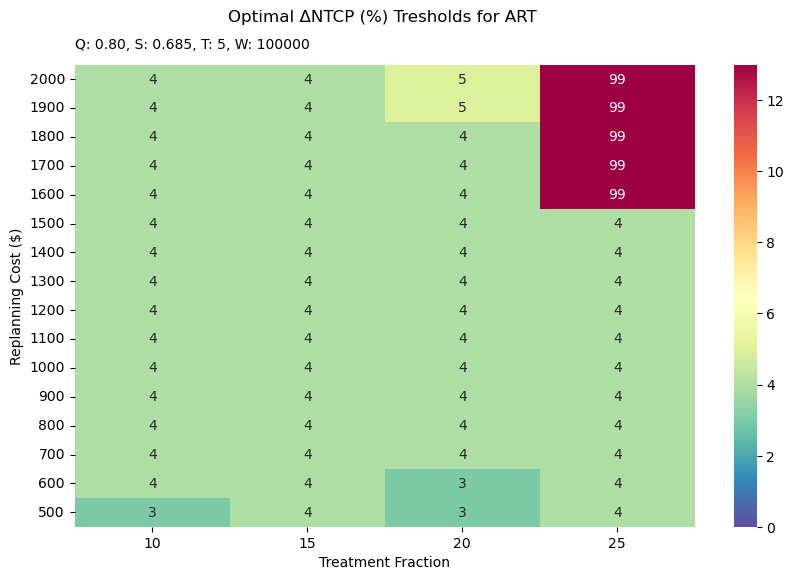

*************
Cost = $ 500
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F20: (0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 ***Thresholds:  [3, 4, 3, 4] 

State Values:
F00: -872.6
F10: [ -538.5  -697.   -931.5 -1197.  -1197.  -1431.5 -1431.5 -1431.5 -1753.
 -1753.  -1753.  -2295.  -2295. ]
F15: [ -460.9  -691.6  -998.6 -1479.8 -1498.6 -1979.8 -1979.8 -3398.4 -3398.4
 -3906.7 -3906.7 -4238.1 -4238.1]
F20: [ -353.5  -687.  -1087.1 -1587.1 -2178.3 -2178.3 -3751.8 -4648.4 -4676.
 -4660.2 -5148.4 -5148.4 -5809.3]
F25: [ -205.3  -684.1 -1204.6 -1869.  -2369.  -3889.8 -4129.6 -4629.6 -5301.7
 -5985.9 -5985.9 -6670.8 -7321.6]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0


*************
Cost = $ 600
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 1,

In [9]:
W = 100_000
plot_treshold_costs(Q,S,T,W,costs)
#
for C in costs:
    print('*************')
    print('Cost = $',C)
    print('*************')
    policy, values = Cost_Effective_ART_MDP_run(Q, S, T, W, C)
    display_policy(policy, optimal = True)
    print('\n ***Thresholds: ', policy_to_tresholds(policy), '\n')
    display_values(values)
    print('\n')

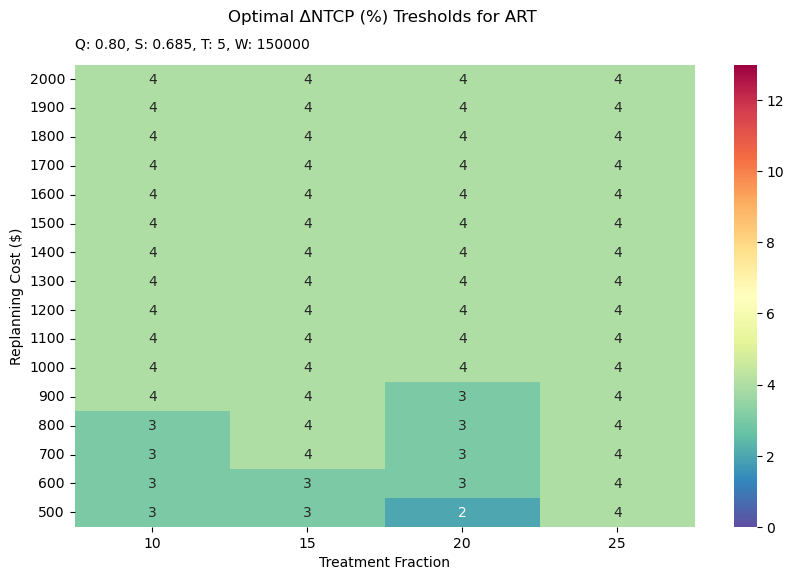

*************
Cost = $ 500
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F20: (0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 ***Thresholds:  [3, 3, 2, 4] 

State Values:
F00: -1187.8
F10: [ -790.2 -1034.  -1328.6 -1534.  -1534.  -1828.6 -1828.6 -1828.6 -2181.5
 -2181.5 -2181.5 -2809.2 -2809.2]
F15: [ -680.8 -1031.4 -1419.7 -1919.7 -1919.7 -2535.7 -2535.7 -4516.4 -4516.4
 -5246.1 -5246.1 -5726.  -5726. ]
F20: [ -530.7 -1031.4 -1531.4 -2129.3 -2973.7 -2973.7 -5246.2 -6537.3 -6537.3
 -6703.3 -7240.4 -7240.4 -8213.9]
F25: [  -308.2  -1027.1  -1808.2  -2804.9  -3304.9  -5585.6  -6194.9  -6694.9
  -7702.3  -8730.2  -8730.2  -9757.3 -10733. ]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0


*************
Cost = $ 600
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0

In [10]:
W = 150_000
plot_treshold_costs(Q,S,T,W,costs)
#
for C in costs:
    print('*************')
    print('Cost = $',C)
    print('*************')
    policy, values = Cost_Effective_ART_MDP_run(Q, S, T, W, C)
    display_policy(policy, optimal = True)
    print('\n ***Thresholds: ', policy_to_tresholds(policy), '\n')
    display_values(values)
    print('\n')

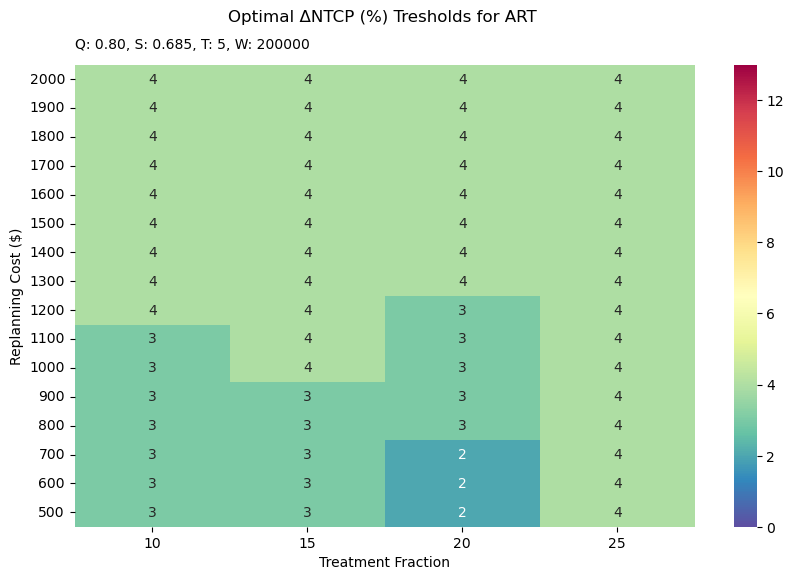

*************
Cost = $ 500
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1)
F20: (0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 ***Thresholds:  [4, 4, 4, 4] 

State Values:
F00: -1693.8
F10: [ -813.6 -1049.8 -1451.6 -2287.1 -3049.8 -3451.6 -3451.6 -3451.6 -4287.1
 -4287.1 -4287.1 -6132.7 -6132.7]
F15: [ -693.3 -1039.3 -1536.  -2612.4 -3536.  -4612.4 -4612.4 -7230.5 -7360.3
 -7964.1 -7964.1 -8270.7 -8270.7]
F20: [  -530.7  -1031.4  -1644.3  -2733.7  -4733.7  -4733.7  -6279.4  -7213.9
  -8240.3  -8279.4  -9213.9  -9213.9 -10240.3]
F25: [  -308.2  -1027.1  -1808.2  -2804.9  -4804.9  -6092.6  -6194.9  -7202.3
  -8230.2  -9257.3 -10230.2 -10335.7 -11733.3]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0


*************
Cost = $ 600
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1)


In [11]:
W = 200_000
plot_treshold_costs(Q,S,T,W,costs)
#
for C in costs:
    print('*************')
    print('Cost = $',C)
    print('*************')
    display_policy(policy, optimal = True)
    print('\n ***Thresholds: ', policy_to_tresholds(policy), '\n')
    display_values(values)
    print('\n')

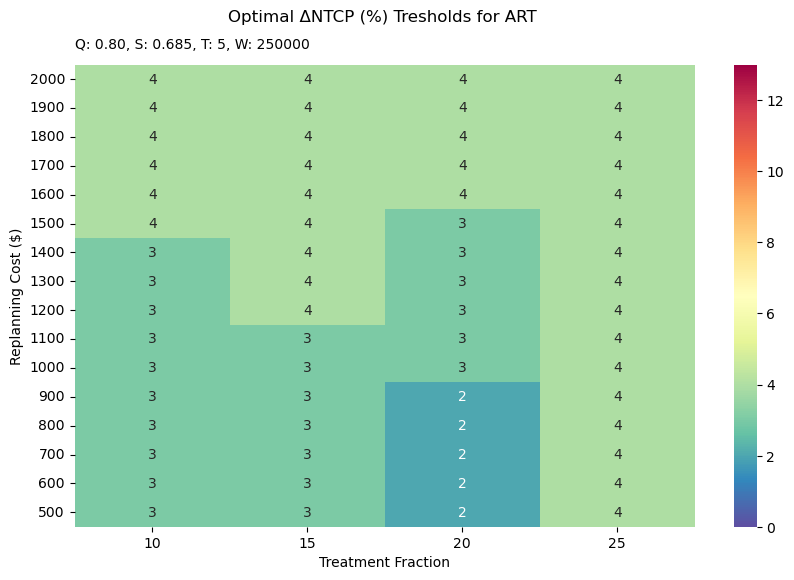

*************
Cost = $ 500
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F15: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F20: (0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F25: (0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1)
F30: (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
F_end: 0

 ***Thresholds:  [3, 3, 2, 4] 

State Values:
F00: -1770.9
F10: [-1259.2 -1684.2 -2022.3 -2184.2 -2184.2 -2522.3 -2522.3 -2522.3 -2898.7
 -2898.7 -2898.7 -3727.5 -3727.5]
F15: [-1098.  -1695.7 -2128.9 -2628.9 -2628.9 -3553.9 -3553.9 -6744.7 -6744.7
 -7899.2 -7899.2 -8695.6 -8695.6]
F20: [  -884.4  -1719.2  -2219.2  -3211.9  -4562.3  -4562.3  -8233.6 -10259.
 -10259.  -10789.4 -11424.6 -11424.6 -13023.4]
F25: [  -513.6  -1712.   -3013.2  -4674.3  -5174.3  -8975.9 -10325.4 -10825.4
 -12504.  -14216.2 -14216.2 -15929.  -17555.6]
F30: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
F_end: 0.0


*************
Cost = $ 600
*************
Optimal Policy:
F00: 0
F10: (0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)
F

In [12]:
W = 250_000
plot_treshold_costs(Q,S,T,W,costs)
#
for C in costs:
    print('*************')
    print('Cost = $',C)
    print('*************')
    policy, values = Cost_Effective_ART_MDP_run(Q, S, T, W, C)
    display_policy(policy, optimal = True)
    print('\n ***Thresholds: ', policy_to_tresholds(policy), '\n')
    display_values(values)
    print('\n')